In [2]:
import numpy as np
import pandas as pd
import os
import pathlib
import matplotlib.pyplot as plt
from bvhpython.bvh import Bvh
from scipy.interpolate import interp1d
import os
import tensorflow as tf
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, Dropout
from keras.losses import SparseCategoricalCrossentropy, mse, CategoricalCrossentropy
from keras.activations import relu
from keras.layers.normalization import BatchNormalization
import datetime
from sklearn.metrics import confusion_matrix
import sklearn
import seaborn as sn

%run Gestion_temps.ipynb


%run Gestion_temps.ipynb
%run modelisation.ipynb
%run bvh_extract.ipynb
%run algo_genetique.ipynb
%load_ext tensorboard

In [3]:
path_bvh_data = 'data/bvh'
path_csv_data = 'data/csv'
path_csv_norm_data = 'data/csv_norm'
path_csv_norm_interp_data = 'data/csv_norm_interp'

# hanche : 1-6
hanche = np.array(range(0,6)) # h

# cuisse droite : 7-12
# mollet droit : 13-18
# pied droit : 19-24
cuisse_droite = np.array(range(6,12)) # cd
mollet_droit = np.array(range(12,18)) # md
pied_droit = np.array(range(18,24)) # pd
jambe_droite = np.array([cuisse_droite,
               mollet_droit,
               pied_droit])

# cuisse gauche : 25-30
# mollet gauche : 31-36
# pied gauche : 37-42
cuisse_gauche = np.array(range(24,30)) # cg
mollet_gauche = np.array(range(30,36)) # mg
pied_gauche = np.array(range(36,42)) # pg
jambe_gauche = np.array([cuisse_gauche,
               mollet_gauche,
               pied_gauche])

# vertebre 43-48
# vertebre 1 : 49-54
# vertebre 2 : 55-60
# vertebre 3 : 61-66
vertebre = np.array(range(42,48)) # v
vertebre_1 = np.array(range(48,54)) # V1
vertebre_2 = np.array(range(54,60)) # v2
vertebre_3 = np.array(range(60,66)) # v3

# nuque : 67-72
# tete : 73-78
nuque = np.array(range(66,72)) # n
tete = np.array(range(72,78)) # t

tronc = np.array([tete,
        nuque,
        vertebre_3,
        vertebre_2,
        vertebre_1,
        vertebre])

# epaule droite : 79-84
# bras droit : 85-90
# avant-bras : 91-96
# main droite : 97-102
epaule_droite = np.array(range(78,84)) # ed
biceps_droit = np.array(range(84,90)) # bd
avant_bras_droit = np.array(range(90,96)) # abd
main_droite = np.array(range(96,102)) # md
bras_droit = np.array([epaule_droite,
             biceps_droit,
             avant_bras_droit,
             main_droite])

# epaule gauche : 217-222
# bras gauche : 223-228
# avant-bras gauche : 229-234
# main gauche : 235-240
epaule_gauche = np.array(range(216,222)) # eg
biceps_gauche = np.array(range(222,228)) # bg
avant_bras_gauche = np.array(range(228,234)) # abg
main_gauche = np.array(range(234,240)) # mg
bras_gauche = np.array([epaule_gauche,
              biceps_gauche,
              avant_bras_gauche,
              main_gauche])

corp = np.array([tronc,
       bras_droit,
       bras_gauche,
       jambe_droite,
       jambe_gauche])

corp_flat = np.array([])
for i in corp:
    for j in i:
        corp_flat = np.append(corp_flat, j)
        
corp_flat = np.sort(corp_flat)

In [4]:
np.where(corp_flat==96)[0][0]

90

In [12]:
list_csv = os.listdir(path_csv_data)
print(list_csv)

['marche_3Char00.bvh.csv', 'marche_jb_3Char00.bvh.csv', 'marche_4Char00.bvh.csv', '11Char00.bvh.csv', 'marche_p_3Char00.bvh.csv', 'marche_pChar00.bvh.csv', 'marche_chuChar00.bvh.csv', 'marche_p_4Char00.bvh.csv', '12Char00.bvh.csv', 'marche_jbChar00.bvh.csv', 'marcheChar00.bvh.csv', 'marche_p_5Char00.bvh.csv', 'marche_p_2Char00.bvh.csv', 'marche_p_6Char00.bvh.csv', 'marche_p_7_bdChar00.bvh.csv', 'marche_5Char00.bvh.csv', 'marche_1Char00.bvh.csv', 'marche_jb_2Char00.bvh.csv', 'marche_2Char00.bvh.csv']


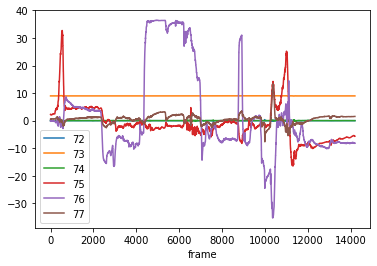

In [59]:
f = '11Char00.bvh.csv'

px = pd.read_csv(path_csv_data + '/' + f)['72']
py = pd.read_csv(path_csv_data + '/' + f)['73']
pz = pd.read_csv(path_csv_data + '/' + f)['74']

rx = pd.read_csv(path_csv_data + '/' + f)['75']
ry = pd.read_csv(path_csv_data + '/' + f)['76']
rz = pd.read_csv(path_csv_data + '/' + f)['77']

px.plot()
py.plot()
pz.plot()

rx.plot()
ry.plot()
rz.plot()

plt.xlabel('frame')
plt.legend()


26.305849 27.967223999999998
5.413116285368152 6.483350575775572


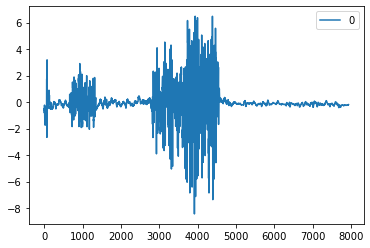

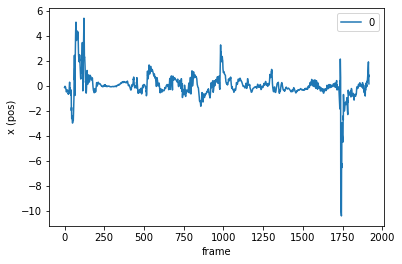

In [66]:
f = 'marche_p_5Char00.bvh.csv'
m_p5_md = pd.read_csv(path_csv_data + '/' + f)['96']

f = 'marcheChar00.bvh.csv'
m_md = pd.read_csv(path_csv_data + '/' + f)['96']

print(max(abs(m_md)), max(abs(m_p5_md)))

m_p5_md = pd.DataFrame(sklearn.preprocessing.scale(m_p5_md))
m_md = pd.DataFrame(sklearn.preprocessing.scale(m_md))

#m_p5_md = m_p5_md + abs(min(m_p5_md))
#m_md = m_md + abs(min(m_md))

print(max(m_md[0]), max(m_p5_md[0]))

#m_p5_md_norm = m_p5_md / max(m_p5_md)
#m_md_norm = m_md / max(m_p5_md)

m_p5_md.plot()
m_md.plot()
plt.ylabel('x (pos)')
plt.xlabel('frame')
plt.legend()

In [15]:

for f in list_csv:
    df = pd.read_csv(path_csv_data + '/' + f,index_col=0, dtype='float')
    # trie de données
    # on récupère que les données utiles du corp
    df = pd.DataFrame(np.array([df[str(int(x))] for x in corp_flat]).T)
    # normalisation des données entre 0 et 1
    
    for v in corp_flat:
        v = np.where(corp_flat==v)[0][0]
        #df[v] = df[v] + abs(min(df[v]))
        df[v] = sklearn.preprocessing.scale(df[v])
        df[v] = df[v] / max(abs(df[v]))
        
    
    df.to_csv(path_csv_norm_data + '/' + f)
    

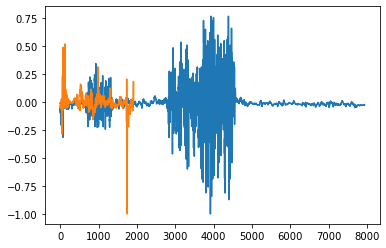

In [16]:
f = 'marche_p_5Char00.bvh.csv'
df = pd.read_csv(path_csv_norm_data + '/' + f, index_col=0)
df['90'].plot()

f = 'marcheChar00.bvh.csv'
m_md = pd.read_csv(path_csv_norm_data + '/' + f, index_col=0)
m_md['90'].plot()

In [17]:

for f in list_csv:
    #df = pd.read_csv(path_csv_norm_data + '/' + f).to_numpy()[1:]
    df = pd.read_csv(path_csv_norm_data + '/' + f,index_col=0)
    function = interp1d(np.array(range(df.shape[0])),df,axis=0,
                       kind='cubic')
    m = pd.DataFrame(function(np.linspace(0,df.shape[0]-1,16000)))
    m.to_csv(path_csv_norm_interp_data + '/' + f)
    


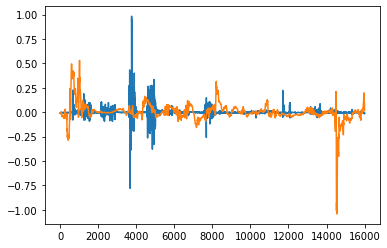

In [39]:
f = '12Char00.bvh.csv'
df = pd.read_csv(path_csv_norm_interp_data + '/' + f, index_col=0)
df['90'].plot()

f = 'marcheChar00.bvh.csv'
df1 = pd.read_csv(path_csv_norm_interp_data + '/' + f, index_col=0)
df1['90'].plot()

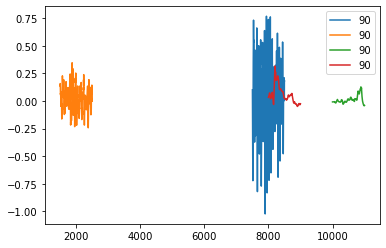

In [20]:
df['90'][7500:8500].plot()
df['90'][1500:2500].plot()
df1['90'][10000:11000].plot()
df1['90'][8000:9000].plot()

plt.legend()

In [21]:
x_train = np.array([[df['90'][7500:8500]],
                    [df['90'][1500:2500]],
                    [df1['90'][10000:11000]],
                    [df1['90'][8000:9000]]])
y_train = np.array([[0,1],[0,1],[1,0],[1,0]])


In [22]:
model = Sequential()

model.add(LSTM(10, 
                activation="tanh",
                return_sequences=True,
                input_shape=(1,1000),
                recurrent_dropout=0.8))
model.add(LSTM(10,
                recurrent_dropout=0.8))
model.add(Dense(2,
                activation='softmax'))
model.compile( loss = "categorical_crossentropy", 
                optimizer = optimizers.Adam(lr = 0.01),
                metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 10)             40440     
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                840       
_________________________________________________________________
dense (Dense)                (None, 2)                 22        
Total params: 41,302
Trainable params: 41,302
Non-trainable params: 0
_________________________________________________________________


[0.5, 1.0]
[0.6919972896575928, 0.6465195417404175]


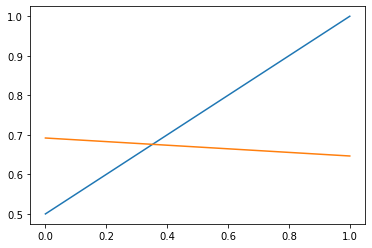

In [54]:
history = model.fit(x_train,y_train,epochs=2,verbose=0)
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
print(history.history['accuracy'])
print(history.history['loss'])

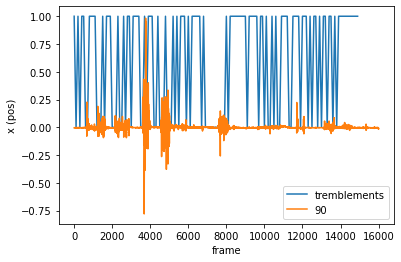

In [26]:
res = np.array([])
f = '12Char00.bvh.csv'
df_test = pd.read_csv(path_csv_norm_interp_data+'/'+f,index_col=0)

for i in range(0,15000,100):
    test = np.array([[df_test['90'][i:i+1000]]])
    prediction = model.predict(test)
    res = np.append(res,prediction.argmax())
    
ordo = np.array(range(0,15000,100))
plt.plot(ordo,res,label='tremblements')
df_test['90'].plot()
plt.ylabel('x (pos)')
plt.xlabel('frame')
plt.legend()
#res

## 